<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/main/Brutyan%20Ruben/3_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_3_class_%D0%B4%D1%83%D0%B6%D0%BA%D0%B8_(Keras_Tuner).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка библиотек

In [ ]:
# загрузка модуля os для работы с ОС (создание\удаление файлов\директорий, информация о текущей рабочей директории, управление процессами и т.д.)
import os

# сохранение данных в файл
import pickle

# импорт библиотеки NumPy (абота с многомерными массивами и матрицами)
import numpy as np

# загрузка модуля ImageDataGenerator из библиотеки tensorflow генерации данных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# нормализация изображений, согласно предварительным требованиям VGG16
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, SpatialDropout2D  # слои (нормализации, регуляризации и т.д)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# создание графиков и визуализаций в Python
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
# методы для отрисовки изображений, обработки и манипулирования изображениями
from PIL import Image
# генерация случайных чисел
import random

from sklearn.metrics import confusion_matrix

## Начальные данные

In [ ]:
# Параметры для ImageDataGenerator:
img_height = 224
img_width = 224

batch_size = 960
validation_split = 0.2

# Путь к папкам с изображениями Train/Test
train_dir = '/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train'
test_dir = '/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/test'

# Путь к папкам-классам изображений для Train
TRAIN_IMAGE_PATH_leska = '/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train/leska'
TRAIN_IMAGE_PATH_obodok = '/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train/obodok'
TRAIN_IMAGE_PATH_vtulka = '/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train/vtulka'

# Путь к папкам-классам изображений для Test
TEST_IMAGE_PATH_leska = '/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/test/leska'
TEST_IMAGE_PATH_obodok = '/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/test/obodok'
TEST_IMAGE_PATH_vtulka = '/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/test/vtulka'

# Список имен классов для Train/Test
TRAIN_CLASS_LIST = sorted(os.listdir(train_dir))
TEST_CLASS_LIST = sorted(os.listdir(test_dir))

# Количество классов для Train/Test
TRAIN_CLASS_COUNT = len(TRAIN_CLASS_LIST)
TEST_CLASS_COUNT = len(TEST_CLASS_LIST)

# Количество всех изображений для Train/Test
train_samples = len(os.listdir(TRAIN_IMAGE_PATH_leska)) + len(os.listdir(TRAIN_IMAGE_PATH_obodok))+len(os.listdir(TRAIN_IMAGE_PATH_vtulka))
test_samples = len(os.listdir(TEST_IMAGE_PATH_leska)) + len(os.listdir(TEST_IMAGE_PATH_obodok))+ len(os.listdir(TEST_IMAGE_PATH_vtulka))

# Создание x_ , y_ и меток

## Генераторы

In [ ]:
# Генератор изображений с аугментацией данных:
datagen = ImageDataGenerator(
    # rescale=1. / 255,                             # Перескалирование значений пикселей изображений, чтобы они находились в диапазоне от 0 до 1
    rotation_range=12,                            # Случайное повороты в диапазоне [-12, 12] градусов
    width_shift_range=4.0,                        # Случайное горизонтальное смещение в диапазоне [-5.0, 5.0] (в долях от общей ширины изображения)
    height_shift_range=5.0,                       # Случайное вертикальное смещение в диапазоне [-5.0, 5.0]
    # shear_range=0.1,                              # диапазон сдвига изображений по горизонтали или вертикали в процентах (изображение может быть сдвинуто на максимум 10% от исходного размера)
    zoom_range=0.1,                               # Случайное масштабирование (увеличение или уменьшение) в диапазоне от 0.9 до 1.1 раз (если 0.2 - от 0.8 до 1.2)
    horizontal_flip=True,                         # Случайное отражение изображений по горизонтали
    fill_mode='nearest',                          # при появлении новых пикселей после преобразований будет использоваться ближайший существующий пиксель для заполнения новых пикселей
    validation_split=validation_split,            # Доля данных, отводимая под валидацию от общего количества фото
    preprocessing_function=preprocess_input       # Нормализация изображений, согласно предварительным требованиям VGG16
)

# Генератор данных для ОБУЧЕНИЯ на основе изображений из каталога
train_generator = datagen.flow_from_directory(
    train_dir,                                    # Путь к изображениям обучающей выборки
    target_size=(img_height, img_width),          # Размер изображений
    batch_size=batch_size,                        # Размер пакета данных
    class_mode='categorical',                     # Тип задачи классификации
    # shuffle=False,                                # Не перемешивание выборки
    shuffle=True,                                 # Перемешивание выборки
    subset='training',                            # Указываем, что это обучающая выборка
    seed=566                                      # Начальное состояние генератора, позволяет повторять повторяемость результатов при каждом запуске кода
)

# Генератор данных для ПРОВЕРКИ на основе изображений из каталога
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # shuffle=False,
    shuffle=True,
    subset='validation',                           # Указываем, что это валидационная выборка
    seed=565
)

# Генератор для тестового набора данных, без аугментации
# test_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input                                     # нормализация изображений, согласно предварительным требованиям VGG16
)

# Генератор данных для ТЕСТИРОВАНИЯ на основе изображений из каталога
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 960 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


## Данные и метки: x_ , y_

### Распределение меток (подбор batch_size = 32 seed=42)

In [ ]:
def Проверка_меток(arr):
    count_100 = np.count_nonzero((arr == [1, 0, 0]).all(axis=1))
    count_010 = np.count_nonzero((arr == [0, 1, 0]).all(axis=1))
    count_001 = np.count_nonzero((arr == [0, 0, 1]).all(axis=1))
    return count_100, count_010, count_001

def Печать_меток(count_100_, count_010_, count_001_):
    print("Количество элементов [1. 0. 0.] в массиве:", count_100_)
    print("Количество элементов [0. 1. 0.] в массиве:", count_010_)
    print("Количество элементов [0. 0. 1.] в массиве:", count_001_)

In [ ]:
# Получаем данные и соответствующие им метки для обучения
x_train, y_train = train_generator.next()

for i in range(len(TRAIN_CLASS_LIST)):
    print(f'У класса "{TRAIN_CLASS_LIST[i]}" метка-{i}.', end=' ')

print('\n\nРаспределение данных в y_train:')
count_100_train, count_010_train, count_001_train = Проверка_меток(np.array(y_train))
Печать_меток(count_100_train, count_010_train, count_001_train)

print(f'Всего: {count_100_train+count_010_train+count_001_train}')

У класса "leska" метка-0. У класса "obodok" метка-1. У класса "vtulka" метка-2. 

Распределение данных в y_train:
Количество элементов [1. 0. 0.] в массиве: 320
Количество элементов [0. 1. 0.] в массиве: 320
Количество элементов [0. 0. 1.] в массиве: 320
Всего: 960


In [ ]:
# Получаем данные и соответствующие им метки для валидации
x_val, y_val = val_generator.next()

for i in range(len(TRAIN_CLASS_LIST)):
    print(f'У класса "{TRAIN_CLASS_LIST[i]}" метка-{i}.', end=' ')

print('\n\nРаспределение данных в y_val:')
count_100_val, count_010_val, count_001_val = Проверка_меток(np.array(y_val))
Печать_меток(count_100_val, count_010_val, count_001_val)
print(f'Всего: {count_100_val+count_010_val+count_001_val}')

У класса "leska" метка-0. У класса "obodok" метка-1. У класса "vtulka" метка-2. 

Распределение данных в y_val:
Количество элементов [1. 0. 0.] в массиве: 80
Количество элементов [0. 1. 0.] в массиве: 80
Количество элементов [0. 0. 1.] в массиве: 80
Всего: 240


In [ ]:
# Получаем данные и соответствующие им метки для тестирования
x_test, y_test = test_generator.next()

for i in range(len(TEST_CLASS_LIST)):
    print(f'У класса "{TEST_CLASS_LIST[i]}" метка-{i}.', end=' ')

print('\n\nРаспределение данных в y_test:')
count_100_test, count_010_test, count_001_test = Проверка_меток(np.array(y_test))
Печать_меток(count_100_test, count_010_test, count_001_test)
print(f'Всего: {count_100_test+count_010_test+count_001_test}')

У класса "leska" метка-0. У класса "obodok" метка-1. У класса "vtulka" метка-2. 

Распределение данных в y_test:
Количество элементов [1. 0. 0.] в массиве: 102
Количество элементов [0. 1. 0.] в массиве: 102
Количество элементов [0. 0. 1.] в массиве: 102
Всего: 306


# Проверки

## Изображения

Изображение из Train-обучающей выборки:


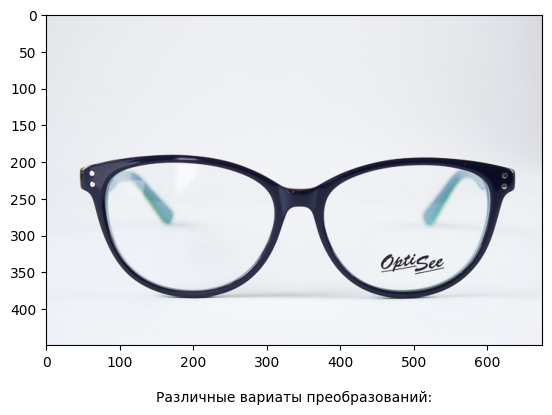

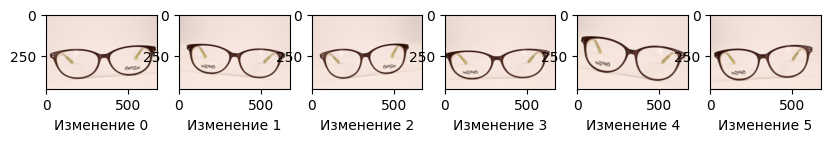

In [ ]:
# Изображение из Train
print('Изображение из Train-обучающей выборки:')
image_file_name = f'{train_dir}/obodok' + '/optisee-sr6077-c01-s2-2 (2).jpg'
img = image.load_img(image_file_name, target_size=(450, 675))
plt.xlabel("\nРазличные вариаты преобразований:")           # добавляем метку к изображению
plt.imshow(img)

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
# Создание заготовки для изображений
fig, axs = plt.subplots(1, 6, figsize=(10, 5))

# Различные виды сгенерированных изображений
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(1, 6, i+1)                      # изменяем параметры subplot для вывода в одну строку
    plt.xlabel("Изменение " + str(i))           # добавляем метку к изображению
    plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break

plt.show()

Случайное TRAIN (с аугментацией) -изображение из каждого класса:
Случайное TEST (без аугментации)-изображение из каждого класса:


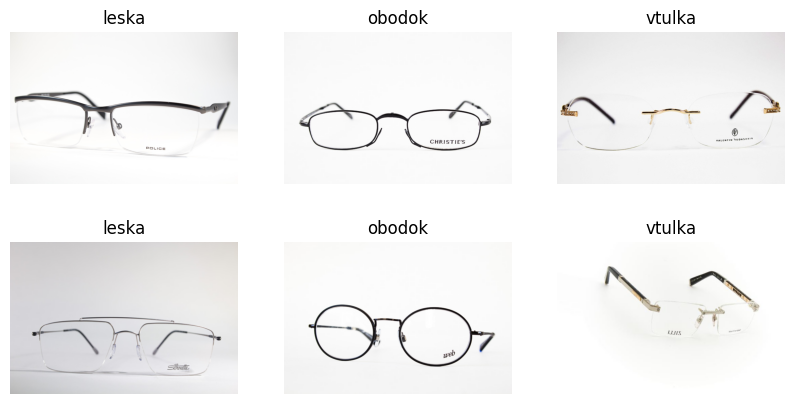

In [ ]:
print('Случайное TRAIN (с аугментацией) -изображение из каждого класса:')

# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# Для всех номеров классов:
for i in range(len(TRAIN_CLASS_LIST)):

    # Формирование пути к папке содержимого класса
    class_path = f'{train_dir}/{TRAIN_CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = class_path + random.choice(os.listdir(class_path))

    # Отображение фотографии
    axs[0,i].set_title(TRAIN_CLASS_LIST[i])
    axs[0,i].imshow(Image.open(img_path))
    axs[0,i].axis('off')

print('Случайное TEST (без аугментации)-изображение из каждого класса:')

# Для всех номеров классов:
for i in range(3):

    # Формирование пути к папке содержимого класса
    class_path = f'{test_dir}/{TEST_CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = class_path + random.choice(os.listdir(class_path))

    # Отображение фотографии
    axs[1,i].set_title(TEST_CLASS_LIST[i])
    axs[1,i].imshow(Image.open(img_path))
    axs[1,i].axis('off')
# Отрисовка всего полотна
plt.show()

## Проверка размерностей

In [ ]:
print('Размерность (Количество элементов, размеры, RGB):')
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val:', x_val.shape)
print('y_val:', y_val.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

print('\nТип данных:')
print('x_train:', type(x_train))
print('y_train:', type(y_train))
print('x_val:', type(x_val))
print('y_val:', type(y_val))
print('x_test:', type(x_test))
print('y_test:', type(y_test))

Размерность (Количество элементов, размеры, RGB):
x_train: (960, 224, 224, 3)
y_train: (960, 3)
x_val: (240, 224, 224, 3)
y_val: (240, 3)
x_test: (306, 224, 224, 3)
y_test: (306, 3)

Тип данных:
x_train: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
x_val: <class 'numpy.ndarray'>
y_val: <class 'numpy.ndarray'>
x_test: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>


# Сохранение/Загрузка

## Сохранение x-y_train_val_test

In [ ]:
# Сохранение x_train y_train и x_val y_val
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/x_train-3class.pickle', 'wb') as file:
    pickle.dump(x_train, file)
print('x_train сохранено')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/y_train-3class.pickle', 'wb') as file:
    pickle.dump(y_train, file)
print('y_train сохранено')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/x_val-3class.pickle', 'wb') as file:
    pickle.dump(x_val, file)
print('x_val сохранено')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/y_val-3class.pickle', 'wb') as file:
    pickle.dump(y_val, file)
print('y_val сохранено')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/x_test-3class.pickle', 'wb') as file:
    pickle.dump(x_test, file)
print('x_test сохранено')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/y_test-3class.pickle', 'wb') as file:
    pickle.dump(y_test, file)
print('y_test сохранено')

x_train сохранено
y_train сохранено
x_val сохранено
y_val сохранено
x_test сохранено
y_test сохранено


## Загрузка x-y_train_val

In [ ]:
# Загрузка x_train y_train и x_val y_val
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/x_train-3class.pickle', 'rb') as file:
    x_train = pickle.load(file)
print('x_train загружен')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/y_train-3class.pickle', 'rb') as file:
    y_train = pickle.load(file)
print('y_train загружен')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/x_val-3class.pickle', 'rb') as file:
    x_val = pickle.load(file)
print('x_val загружен')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/y_val-3class.pickle', 'rb') as file:
    y_val = pickle.load(file)
print('y_val загружен')

x_train загружен
y_train загружен
x_val загружен
y_val загружен


## Загрузка x-y_test

In [ ]:
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/x_test-3class.pickle', 'rb') as file:
    x_test = pickle.load(file)
print('x_test загружен')
with open('/content/drive/MyDrive/НетОптик/Dataset/DS_3classes/train_test-pickle/y_test-3class.pickle', 'rb') as file:
    y_test = pickle.load(file)
print('y_test загружен')

x_test загружен
y_test загружен


# ПОДБОР Г-Параметров

## Загрузка обученной VGG16

In [ ]:
# Загрузка библиотек для модели
from keras.applications import VGG16

# Загрузка модели VGG16 без весов ImageNet
# model = VGG16(weights=None, include_top=True)

# Загружаем предварительно обученную нейронную сеть
vgg16_net = VGG16(weights='imagenet',                         # признаки из набора данных "ImageNet"
                  include_top=False,                          # отключаем часть "классификация", оставляем только "сверточную часть"
                  input_shape=(img_height, img_width, 3))     # размер тензора входных изображений

# "Замораживаем" веса предварительно обученной нейронной сети VGG16 (сверточная часть обучаться не будет)
vgg16_net.trainable = False

# архитектура vgg16_net
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Установка Keras Tuner

In [ ]:
# Установка keras tuner
!pip install -q keras-tuner
# загрузка функций из библиотеки Keras
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization

Using TensorFlow backend


## Функции создания нейронной сети

### из 4 переменных

In [ ]:
# переменные для подбора: activation, units_hidden, rate_Dropout, optimizer

def build_model(hp):
    model = Sequential()
    # Добавляем в модель сеть VGG16 вместо слоя
    model.add(vgg16_net)
    # функции активации
    # activation_choice = hp.Choice('activation', values=['relu', 'elu', 'selu', 'tanh', 'sigmoind'])
    activation_choice = hp.Choice('activation', values=['relu', 'elu', 'selu', 'tanh'])

    # Добавляем слои, для классификации
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units_hidden',          # Полносвязный слой с разным количеством нейронов
                                   min_value=128,         # минимальное количество нейронов - 128
                                   max_value=800,         # максимальное количество - 1024
                                   step=32),
                    activation=activation_choice))
    # model.add(Dropout(0.5))
    model.add(Dropout(rate=hp.Float('rate_dropout',       # Полносвязный слой с разным количеством нейронов
                                   min_value=0.4,         # минимальное количество нейронов - 0
                                   max_value=0.8,         # максимальное количество - 1
                                   step=0.2)))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer=hp.Choice('optimizer', values=['Adam','RMSprop','SGD']),
              metrics=['accuracy'])
    return model

### из 3 переменных

In [ ]:
# переменные для подбора: activation, units_hidden, learning_rate

def build_model(hp):
    model = Sequential()
    model.add(vgg16_net)
    activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu', 'tanh', 'sigmoid'])
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units_hidden', min_value=128, max_value=650, step=32), activation=activation_choice))
    model.add(Dropout(rate=hp.Float('rate_dropout', min_value=0.5, max_value=0.6, step=0.1)))
    model.add(Dense(3, activation='softmax'))

    optimizer_choice = hp.Choice('optimizer', values=['Adam','RMSprop','SGD'])

    if optimizer_choice == 'Adam':
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5])), metrics=['accuracy'])
    elif optimizer_choice == 'RMSprop':
        model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5])), metrics=['accuracy'])
    elif optimizer_choice == 'SGD':
        model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5])), metrics=['accuracy'])

    return model

## Создание Tuner-ров

Доступные типы тюнеров:
- RandomSearch - случайный поиск (пространство гиперпараметров НЕ велико)
- BayesianOptimization - байесовская оптимизация (малое количество обучающих примеров или небольшое пространстве гиперпараметров)
- Hyperband - алгоритм оптимизации на основе метода испытаний с отсечением наихудших моделей (на больших наборах данных)
- Greedy (greedy) - последовательный выбор гиперпараметров. Начинает с настройки базовых гиперпараметров (простота и возможность быстрого улучшения результатов)

### RandomSearch

In [ ]:
tuner = RandomSearch(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика на которую настраивается модель, которую нужно оптимизировать -
                                 # доля правильных ответов на проверочном наборе данных (максимизировать точность)
    max_trials=8,                # максимальное количество пробных комбинаций гиперпараметров (НЕ ПОДХОДИТ ДЛЯ БАНДИТА)

    # executions_per_trial=5,      # Количество выполнений (эпох) для каждой комбинации гиперпараметров
    directory='/content/drive/MyDrive/НетОптик/Tuner',    # каталог, куда сохраняются обученные сети
    project_name='randomSearch_trials',                   # название подпапки для randomSearch
    seed = 42
    )

### BayesianOptimization

In [ ]:
tuner = BayesianOptimization(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика на которую настраивается модель, которую нужно оптимизировать -
                                 # доля правильных ответов на проверочном наборе данных (максимизировать точность)
    max_trials=5,                # максимальное количество пробных комбинаций гиперпараметров (НЕ ПОДХОДИТ ДЛЯ БАНДИТА)

    executions_per_trial=1,      # Количество выполнений (эпох) для каждой комбинации гиперпараметров
    directory='/content/drive/MyDrive/НетОптик/Tuner',    # каталог, куда сохраняются обученные сети
    project_name='bayesian_trials',                       # название подпапки для bayesianOptimization
    seed = 42
    )

### Hyperband

In [ ]:
tuner = Hyperband(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика на которую настраивается модель, которую нужно оптимизировать -
                                 # доля правильных ответов на проверочном наборе данных (максимизировать точность)
    max_epochs=10,               # (ДЛЯ БАНДИТА) максимальное количество эпох, которое будет запущено для каждой комбинации гиперпараметров
    factor=3,                    # (ДЛЯ БАНДИТА) параметр уменьшения, связанный с концепцией "половинчатого деления" в методе Hyperband.
                                 # Определяет сколько раз будет уменьшаться максимальное количество эпох после каждой итерации.
                                 # Чем меньше значение, тем больше комбинаций гиперпараметров будет протестировано, но это потребует больше времени на обучениев

    executions_per_trial=3,      # Количество выполнений (эпох) для каждой комбинации гиперпараметров
    directory='/content/drive/MyDrive/НетОптик/Tuner',    # каталог, куда сохраняются обученные сети
    project_name='hyperband_trials',                      # название подпапки для Hyperband
    seed = 42
    )

## Пространство поиска

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu', 'tanh'], 'ordered': False}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 800, 'step': 32, 'sampling': 'linear'}
rate_dropout (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.4, 'max_value': 0.8, 'step': 0.2, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop', 'SGD'], 'ordered': False}


## Запуск подбора ГП

### Callback (с VGG16)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Сохраняем только лучший вариант сети
callbacks = [ModelCheckpoint('/content/drive/MyDrive/НетОптик/Save_models/3_class/best-callback_vgg16.hdf5', monitor='val_accuracy', save_best_only=True)]

# остановка если ухудшение после 5 шагов
stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, verbose=2)

### Обучение

In [ ]:
history_tun = tuner.search(x_train, y_train,
                           batch_size=32,
                           epochs=5,
                           validation_data=(x_val, y_val),
                           # callbacks=callbacks,               # лучший результат
                           callbacks=[stopping_callback],     # остановка после ухудшения
                           verbose=1)

Trial 8 Complete [00h 00m 34s]
val_accuracy: 0.9708333611488342

Best val_accuracy So Far: 0.9708333611488342
Total elapsed time: 00h 05m 13s


In [ ]:
# Проверка того, что записанные в history_tun данные не возвращаются, для их дальнейшего использования (построения графиков)
if history_tun is not None:
    # построение графиков потерь и точности
    print("нет Ошибки в процессе поиска оптимальных гиперпараметров.")
else:
  print("Ошибка в процессе поиска оптимальных гиперпараметров.")

Ошибка в процессе поиска оптимальных гиперпараметров.


# Выбор модели

## Результаты модели

In [ ]:
# результаты обучения, полученные от tuner.search()
results = tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/НетОптик/Tuner/randomSearch_trials
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
activation: selu
units_hidden: 128
rate_dropout: 0.6000000000000001
optimizer: Adam
Score: 0.9708333611488342

Trial 5 summary
Hyperparameters:
activation: tanh
units_hidden: 416
rate_dropout: 0.6000000000000001
optimizer: RMSprop
Score: 0.9708333611488342

Trial 7 summary
Hyperparameters:
activation: tanh
units_hidden: 352
rate_dropout: 0.4
optimizer: Adam
Score: 0.9708333611488342

Trial 1 summary
Hyperparameters:
activation: tanh
units_hidden: 352
rate_dropout: 0.6000000000000001
optimizer: Adam
Score: 0.9666666388511658

Trial 2 summary
Hyperparameters:
activation: elu
units_hidden: 288
rate_dropout: 0.8
optimizer: RMSprop
Score: 0.9666666388511658

Trial 3 summary
Hyperparameters:
activation: tanh
units_hidden: 160
rate_dropout: 0.8
optimizer: Adam
Score: 0.9583333134651184

Trial 4 summary
Hyp

## Выбор пяти лучших моделей

In [ ]:
models = tuner.get_best_models(num_models=5)

## Оценка качества модели на тестовых данных

In [ ]:
for model in models:
  model.summary()
  model.evaluate(x_test, y_test)
  print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17926467 (68.38 MB)
Trainable params: 3211779 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
10/10 [==

### Индекс лучшей модели

In [ ]:
# Индекс лучшей модели
m = 2
scores = models[m].evaluate(x_test, y_test)
print("\nTest_accuracy (точность работы модели) на тестовых данных: %.2f%%" % (scores[1]*100))

10/10 [==============================] - 2s 143ms/step - loss: 0.2954 - accuracy: 0.9216

Test_accuracy (точность работы модели) на тестовых данных: 92.16%


# Сохранить/Загрузить

### *Сохранить модель*

In [ ]:
print('Сохраняем модель')

models[m].save('/content/drive/MyDrive/НетОптик/Save_models/3_class/net_optic(tuner_Random)-3classa.h5')

print('Сохранение сети в файл net_optic(tuner_Random)-3classa.h5 завершено')

Сохраняем сеть


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Сохранение сети в файл net_optic(tuner_Random)-3classa.h5 завершено


## *Загрузить модель*

In [ ]:
from tensorflow.keras.models import load_model

print('Загружаем модель Random')

# Загружаем модель из файла
model = load_model("/content/drive/MyDrive/НетОптик/Save_models/3_class/net_optic(tuner_Random)-3classa.h5")

print('Загрузка сети из файла net_optic(tuner_Random)-3classa.h5 завершена')

# вывод архитектуры модели
print()
model.summary()

Загружаем модель Random
Загрузка сети из файла net_optic(tuner_Random)-3classa.h5 завершена

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 352)               8831328   
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1059      
                                                                 
Total params: 23547075 (89.82 MB)
Trainable params: 8832387 (33.69 MB)
Non-trainable params: 14

# ОЦЕНКА модели

## Точность и функция потерь

In [ ]:
# Вычисляем метрику accuracy
loss, accuracy = models[m].evaluate(x_test, y_test)

# Вывод полученных результатов
print(f'Значение функции потерь на тестовых данных (Loss): {loss}')
print(f'Точность модели на тестовых данных (Accuracy): {accuracy}')

10/10 [==============================] - 1s 133ms/step - loss: 0.2954 - accuracy: 0.9216
Значение функции потерь на тестовых данных (Loss): 0.2953675389289856
Точность модели на тестовых данных (Accuracy): 0.9215686321258545


In [ ]:
# Вычисляем метрику accuracy
loss, accuracy = model.evaluate(x_test, y_test)

# Вывод полученных результатов
print(f'Значение функции потерь на тестовых данных (Loss): {loss}')
print(f'Точность модели на тестовых данных (Accuracy): {accuracy}')

7/7 [==============================] - 149s 21s/step - loss: 0.2950 - accuracy: 0.9346
Значение функции потерь на тестовых данных (Loss): 0.29499828815460205
Точность модели на тестовых данных (Accuracy): 0.9345794320106506


## Предсказания

In [ ]:
# Предсказанные значения
y_predict = models[m].predict(x_test)

10/10 [==============================] - 2s 139ms/step


### Предсказание (вручную)

In [ ]:
num_img = 113
print('Тестовое значение y_test=', y_test[num_img])
print('Предсказанное y_predict =', y_predict[num_img])

y_pred_classes = np.zeros_like(y_predict[num_img])
y_pred_classes[np.argmax(y_predict[num_img])] = 1

print('Предсказанное значение y_predict =', y_pred_classes)

Тестовое значение y_test= [0. 1. 0.]
Предсказанное y_predict = [1.7531083e-29 1.0000000e+00 0.0000000e+00]
Предсказанное значение y_predict = [0. 1. 0.]


# ГРАФИКИ

## График confusion_matrix

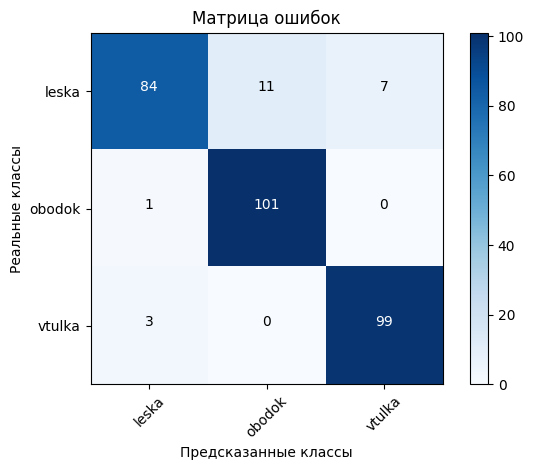

In [ ]:
# Приведение к индексам классов
y_pred_classes = np.argmax(y_predict, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Создание матрицы ошибок
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Визуализация матрицы ошибок
plt.imshow(confusion_mat, cmap='Blues')
plt.title('Матрица ошибок')
plt.colorbar()

labels = TRAIN_CLASS_LIST                     # Названия классов
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Предсказанные классы')
plt.ylabel('Реальные классы')

# Добавление значений в ячейки
thresh = confusion_mat.max() / 2.
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## Расчет метрики precision

Метрика precision показывает: насколько хорошо модель способна отличать выбранный класс от всех остальных.

In [ ]:
import numpy as np

def precision(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)), axis=0)
    precision_scores = true_positives / (predicted_positives + 1e-7)
    return precision_scores

precision_scores = precision(y_test, y_predict)
labels = TRAIN_CLASS_LIST                                       # Названия классов
print('Метки:', labels)
print("Метрика Precision для каждого класса:", precision_scores)

Метки: ['leska', 'obodok', 'vtulka']
Метрика Precision для каждого класса: [0.97590363 0.8947368  0.91588783]


## Метрика recall

Метрика recall показыает насколько хорошо модель в принципе способна находить выбранный класс.

In [ ]:
# Расчет метрики recall для класса пластик
recall_class_l = confusion_mat[0,0] / sum(confusion_mat[0])
print(f'Метрика recall для класса {TRAIN_CLASS_LIST[0]}', recall_class_l)

# Расчет метрики recall для класса металл
recall_class_o = confusion_mat[1,1] / sum(confusion_mat[1])
print(f'Метрика recall для класса {TRAIN_CLASS_LIST[1]}', recall_class_o)

# Расчет метрики recall для класса металл
recall_class_v = confusion_mat[2,2] / sum(confusion_mat[2])
print(f'Метрика recall для класса {TRAIN_CLASS_LIST[2]}', recall_class_v)

Метрика recall для класса leska 0.7941176470588235
Метрика recall для класса obodok 1.0
Метрика recall для класса vtulka 0.9705882352941176


## Метод precision_recall_fscore_support

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Предсказанные значения
# predicted = model.predict(x_test)

predicted = y_predict
predicted = np.argmax(predicted, axis=1)

# Расчет precision, recall, fscore и support
precision, recall, fscore, support = precision_recall_fscore_support(y_true=np.argmax(y_test, axis=1), y_pred=predicted)

print("Support:", support)
print("Precision:", precision)
print("Recall:", recall)
print("F-Score:", fscore)

Support: [102 102 102]
Precision: [0.96428571 0.89473684 0.91666667]
Recall: [0.79411765 1.         0.97058824]
F-Score: [0.87096774 0.94444444 0.94285714]


# Дообучение

In [ ]:
# Индекс лучшей модели
j = m
scores = models[j].evaluate(x_test, y_test)
print("\nTest_accuracy (точность работы модели) на тестовых данных: %.2f%%" % (scores[1]*100))

10/10 [==============================] - 1s 130ms/step - loss: 2.4135 - accuracy: 0.9281

Test_accuracy (точность работы модели) на тестовых данных: 92.81%


In [ ]:
history = models[j].fit(x_train, y_train,
                           batch_size=32,
                           epochs=10,
                           validation_data=(x_val, y_val),
                           # callbacks=callbacks,               # лучший результат
                           callbacks=[stopping_callback],     # остановка после ухудшения
                           verbose=1)

Epoch 1/10
30/30 [==============================] - 7s 180ms/step - loss: 1.7391 - accuracy: 0.9333 - val_loss: 1.5467 - val_accuracy: 0.9583
Epoch 2/10
30/30 [==============================] - 5s 165ms/step - loss: 1.1131 - accuracy: 0.9365 - val_loss: 1.3077 - val_accuracy: 0.9750
Epoch 3/10
30/30 [==============================] - 5s 167ms/step - loss: 1.1380 - accuracy: 0.9406 - val_loss: 1.2113 - val_accuracy: 0.9708
Epoch 4/10
30/30 [==============================] - 5s 173ms/step - loss: 1.2974 - accuracy: 0.9458 - val_loss: 0.7501 - val_accuracy: 0.9708
Epoch 5/10
30/30 [==============================] - 5s 179ms/step - loss: 0.7264 - accuracy: 0.9552 - val_loss: 1.5400 - val_accuracy: 0.9750
Epoch 5: early stopping


## Графики потерь и точности

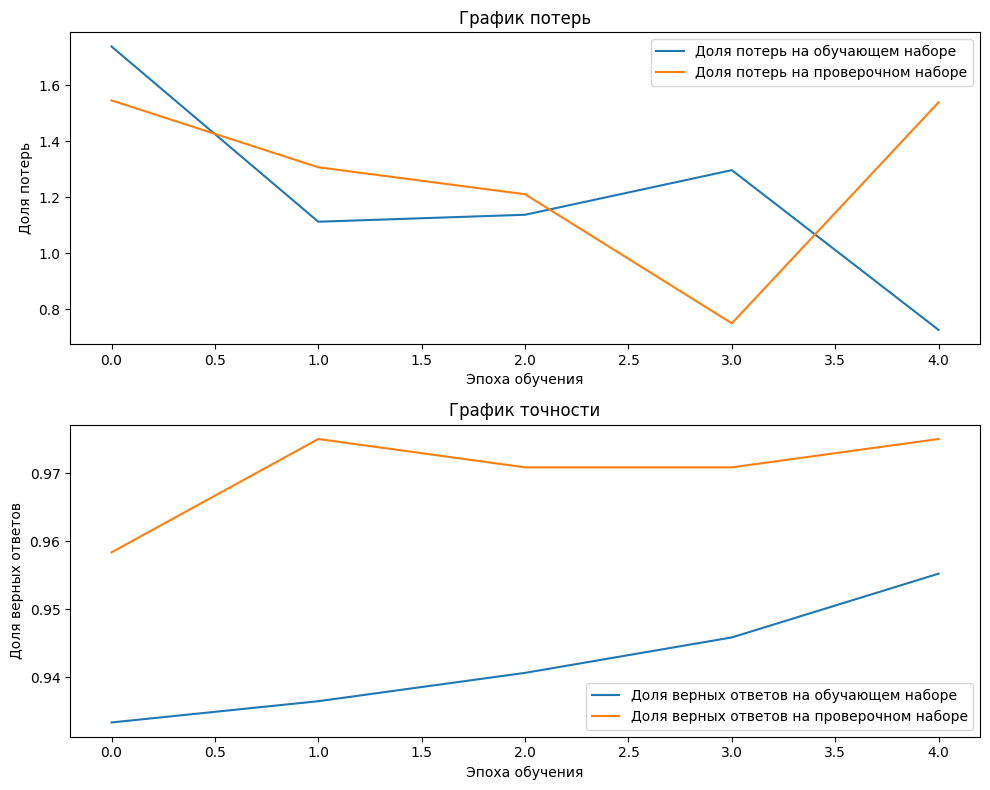

In [ ]:
import matplotlib.pyplot as plt

# Значения потерь и точности из истории обучения
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# График с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# График потерь
ax1.plot(train_loss, label='Доля потерь на обучающем наборе')
ax1.plot(val_loss, label='Доля потерь на проверочном наборе')
ax1.legend()
ax1.set_title('График потерь')
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля потерь')

# График точности
ax2.plot(train_acc, label='Доля верных ответов на обучающем наборе')
ax2.plot(val_acc, label='Доля верных ответов на проверочном наборе')
ax2.legend()
ax2.set_title('График точности')
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Доля верных ответов')

# Отображение графиков
plt.tight_layout()
plt.show()

In [ ]:
y_pred = models[j].predict(x_test)

10/10 [==============================] - 1s 130ms/step


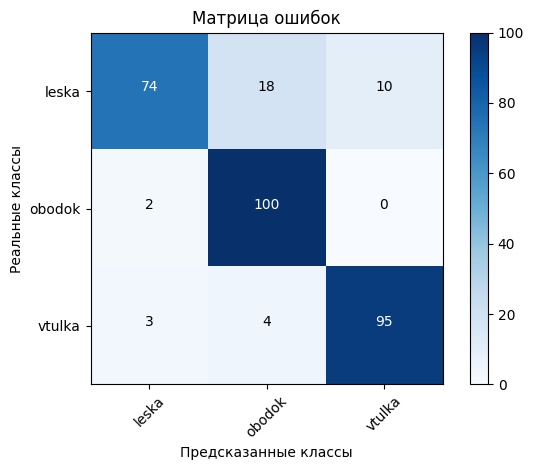

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Предсказанные значения
# y_pred = model.predict(x_test)
# Приведение к индексам классов
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Создание матрицы ошибок
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Визуализация матрицы ошибок
plt.imshow(confusion_mat, cmap='Blues')
plt.title('Матрица ошибок')
plt.colorbar()

labels = TRAIN_CLASS_LIST                     # Названия классов
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Предсказанные классы')
plt.ylabel('Реальные классы')

# Добавление значений в ячейки
thresh = confusion_mat.max() / 2.
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.show()